In [77]:
import numpy as np 
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

## - Waterbody: Petrignano
## - Type: Aquifer

The groundwater levels are influenced by the following parameters:

- Rainfall 
- Depth to groundwater 
- Temperatures and drainage volumes 
- Level of the Chiascio river

In [78]:
df = pd.read_csv("/Users/andreawendezflores/Documents/GitHub/Time-Series/data/raw/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [79]:
df.shape

(5223, 8)

In [80]:
# Obtenemos la información sobre los tipos de datos y valores no nulos del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [81]:
# Usamos el método duplicated() para detectar duplicados en un DataFrame y sum() para contar el número de duplicados.
duplicados = df.duplicated()
num_duplicados = duplicados.sum()

print(duplicados)
print(f'El número de duplicados es: {num_duplicados}')

0       False
1       False
2       False
3       False
4       False
        ...  
5218    False
5219    False
5220    False
5221    False
5222    False
Length: 5223, dtype: bool
El número de duplicados es: 0


In [82]:
# Utilizamos el método 'isna' para conocer cuántos valores nulos hay por columna:
total_nans = df.isna().sum()
total_nans

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

'Temperature_Bastia_Umbra' y 'Temperature_Petrignano' están fuertemente correlacionadas (0.84)

In [83]:
print('Starting date is :' , df['Date'].iloc[0],
      '\nEnding Date is : ',df["Date"].iloc[-1])

Starting date is : 14/03/2006 
Ending Date is :  30/06/2020


- Initial Analysis says :

    - There are missing data in the dataset.
    - The data availability is from 14/03/2006 to 30-Jun-2020.

In [84]:
pd.Series(df.isnull().sum()).rename_axis('features/target').to_frame('Missing Value Count')

,Missing Value Count
features/target,
Date,0
Rainfall_Bastia_Umbra,1024
Depth_to_Groundwater_P24,55
Depth_to_Groundwater_P25,39
Temperature_Bastia_Umbra,1024
Temperature_Petrignano,1024
Volume_C10_Petrignano,198
Hydrometry_Fiume_Chiascio_Petrignano,1024


Este código es útil para generar un informe de cuántos valores nulos existen en cada columna de un DataFrame y para organizar estos resultados en un formato legible, donde se etiquetan tanto las columnas (como features/target) como los valores nulos (Missing Value Count).

## Heat Map for Missing Data:

<Axes: >

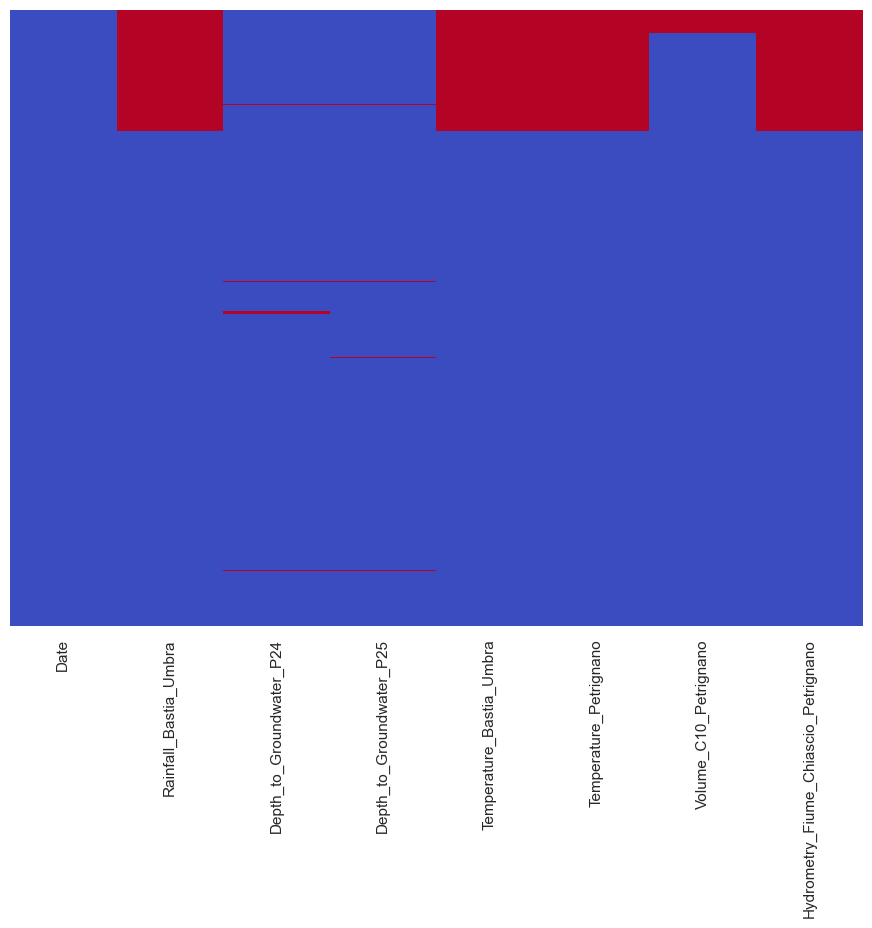

In [85]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

Here entire dataset of Aquifer Petrignano is represented by the blue rectangle and each red strips indicates missing value. 
The value at top of the heat map is the oldest data and at the bottom is the newest one. 

With this visualization it is easy to say that the missing data is the oldest data because it is located at the top of the map, so we can drop those null values rows.

In [86]:
# Eliminamos los valores más antiguos de la columna: 
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Eliminamos las columnas no útiles: 
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [87]:
df.head(10).style.background_gradient(cmap='Dark2_r')

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,02/01/2009,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,03/01/2009,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,04/01/2009,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,05/01/2009,0.000000,-31.010000,-1.900000,-29854.656000,2.300000
5,06/01/2009,0.000000,-31.000000,-0.700000,-29124.576000,2.300000
6,07/01/2009,0.000000,-30.960000,1.500000,-31173.120000,2.300000
7,08/01/2009,0.000000,-30.940000,4.300000,-30232.224000,2.400000
8,09/01/2009,0.900000,-30.930000,4.900000,-30597.696000,2.300000
9,10/01/2009,0.000000,-30.870000,1.900000,-31337.280000,2.300000


In [88]:
print('Starting date After Deletion of old  missing data is :' ,      
      df['Date'].iloc[0],
      '\nEnding Date  After Deletion of old missing data is : ',      
      df['Date'].iloc[-1])

Starting date After Deletion of old  missing data is : 01/01/2009 
Ending Date  After Deletion of old missing data is :  30/06/2020


After deletion of old data, the data is from 01/01/2009 to 30/06/2020.

## Correlation Analysis: 

In [94]:
# Simplificamos el nombre de las columnas:
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


Due to we have a Time Series problem, we need to parse the 'Date' column:

In [97]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## Data Visualization: 

- Features:

    - Rainfall indicates the quantity of rain falling (mm)
    - Temperature indicates the temperature (°C)
    - Volume indicates the volume of water taken from the drinking water treatment plant (m³)
    - Hydrometry indicates the groundwater level (m)

- Target:

    - Depth to Groundwater indicates the groundwater level (m from the ground floor)

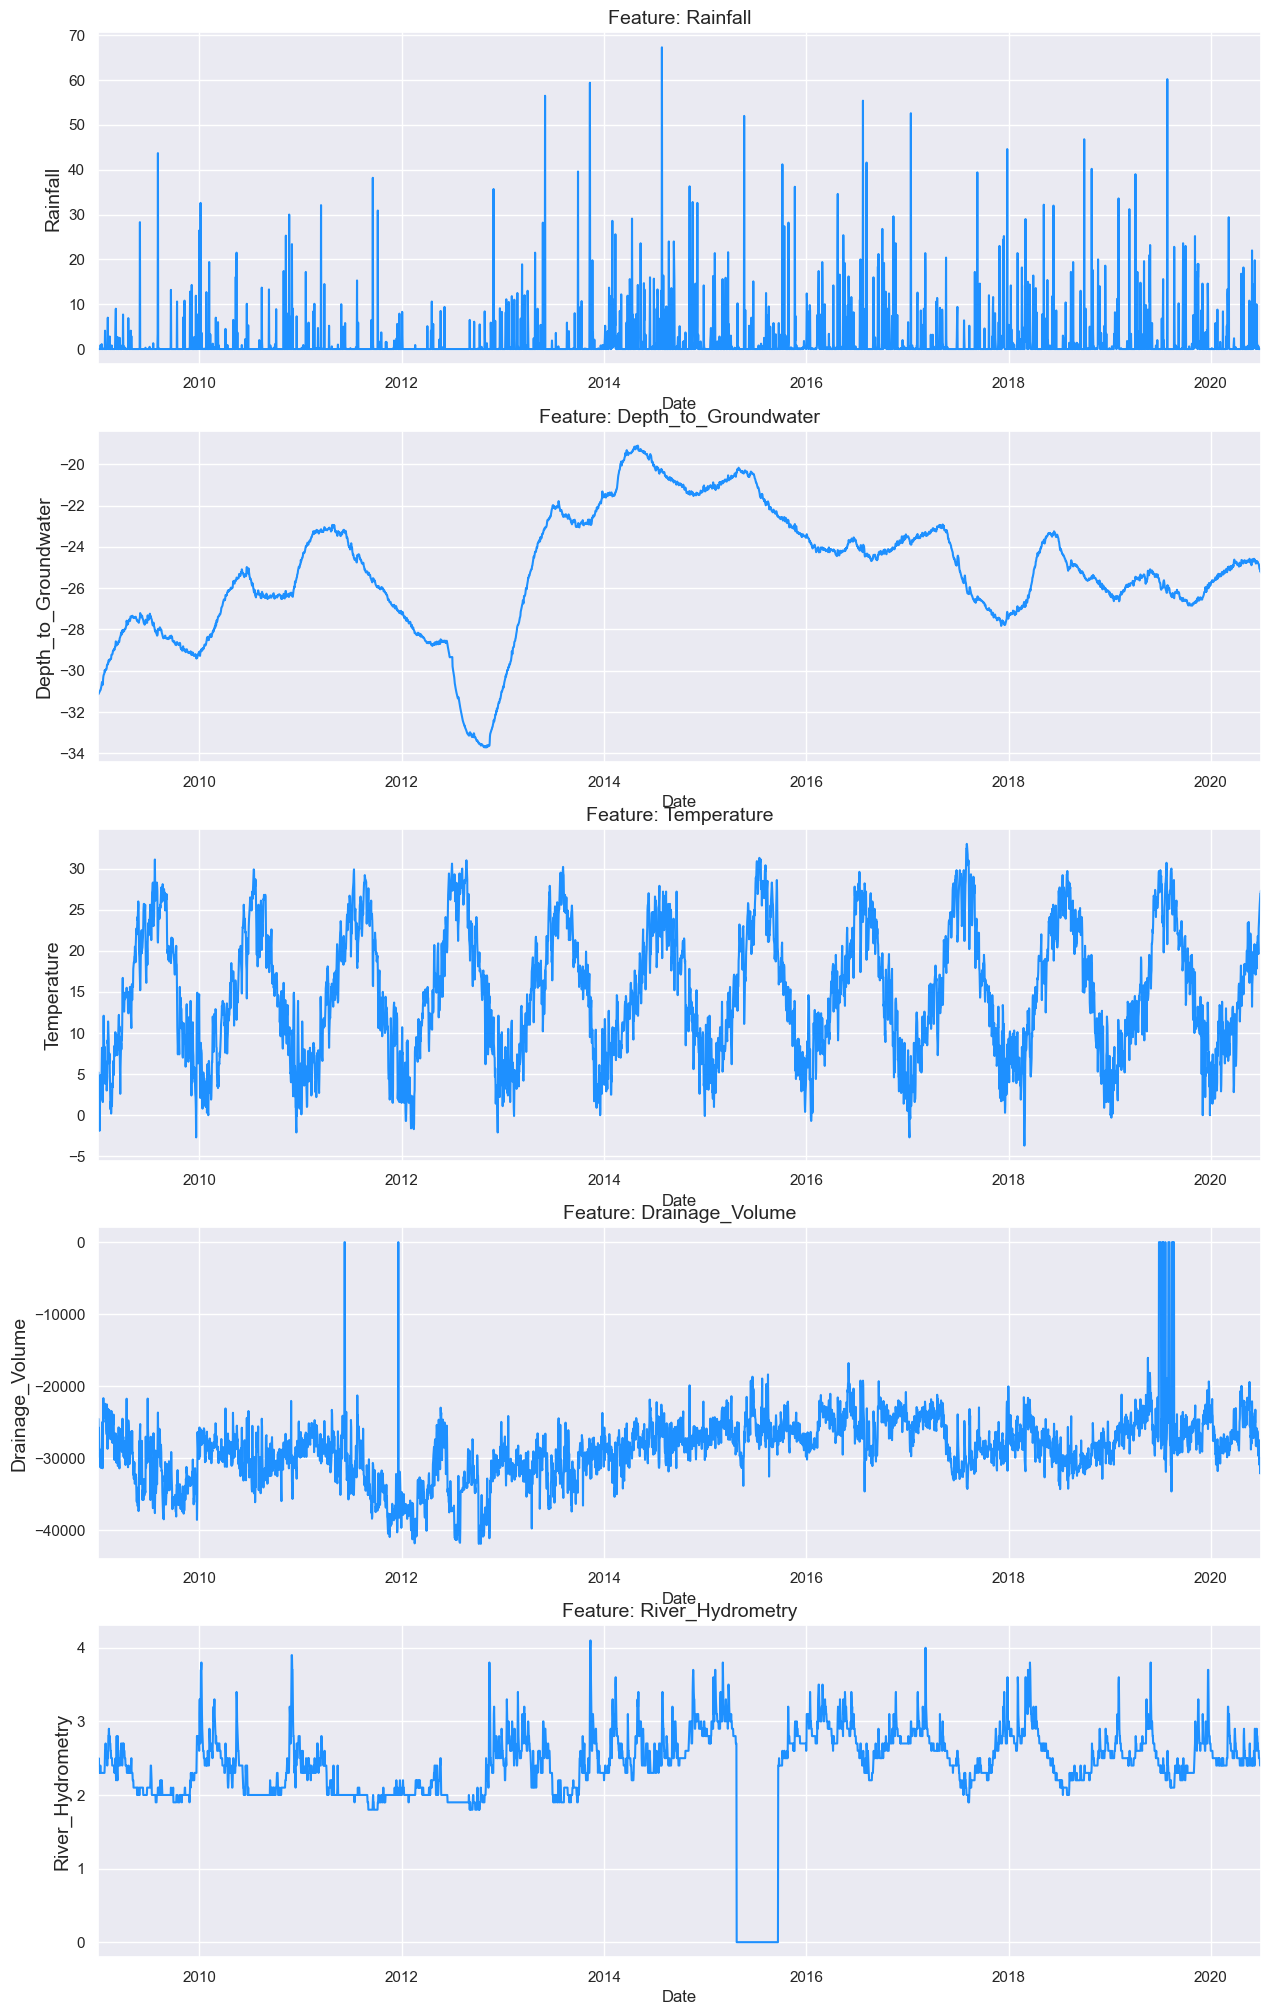

In [99]:
# To complete the data, as naive method, we will use .ffill()
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])    

## Data Preprocessing:

Let's see how to check if our dataset is correctly formatted!

The data should be in chronological order, and the timestamps should be equidistant in time series.

In [102]:
df = df.sort_values(by='Date')

# Check time intervals
df['delta'] = df['Date'] - df['Date'].shift(1)

df[['Date', 'delta']].head()

,Date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [103]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

This is already the case in our data: 

The time interval is one day, and the data is already in chronological order. 

Therefore, we do not have to do this additional data preparation step.

In [104]:
# Handle Missings: 
df = df.drop('delta', axis=1)
df.isna().sum()

Date                     0
Rainfall                 0
Depth_to_Groundwater    27
Temperature              0
Drainage_Volume          1
River_Hydrometry         0
dtype: int64

As we can see, the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be some zero values that seem to be nulls for 'drainage_volume', and 'river_hydrometry'. 

We will have to clean them by replacing them with NaN values and filling them afterward.

(14245.0, 18443.0)

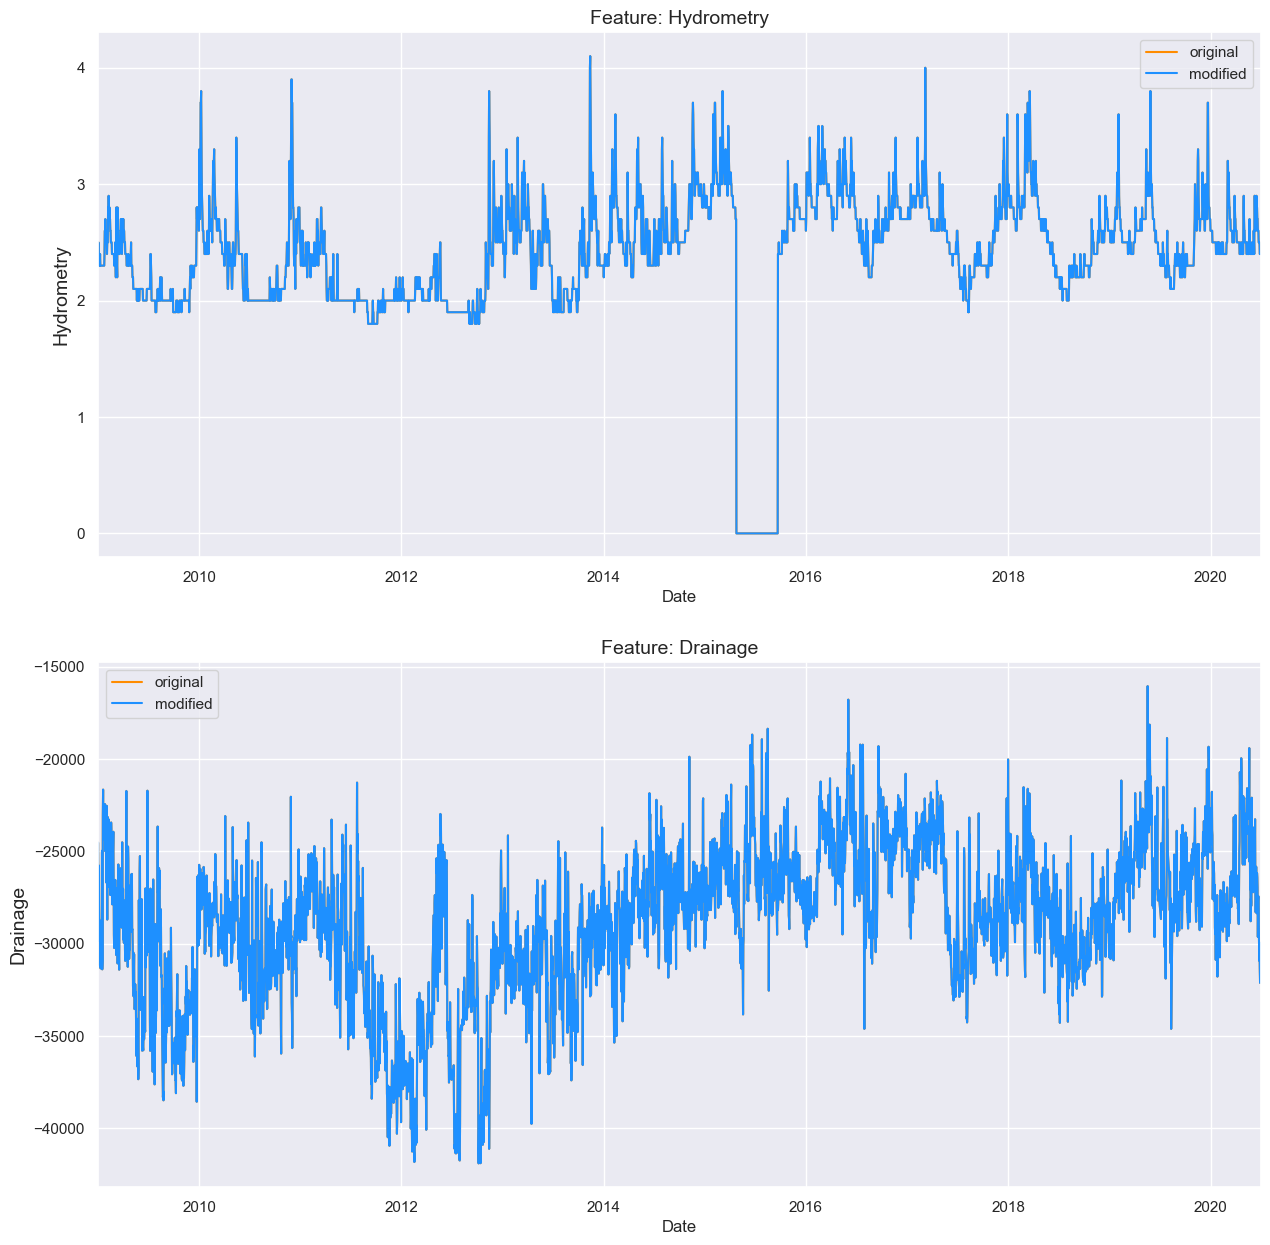

In [106]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['River_Hydrometry'].copy()
df['River_hHdrometry'] = df['River_Hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['Date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['Date'], y=df['River_Hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['Drainage_Volume'].copy()
df['Drainage_Volume'] = df['Drainage_Volume'].replace(0, np.nan)

sns.lineplot(x=df['Date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

AttributeError: 'YTick' object has no attribute 'label'

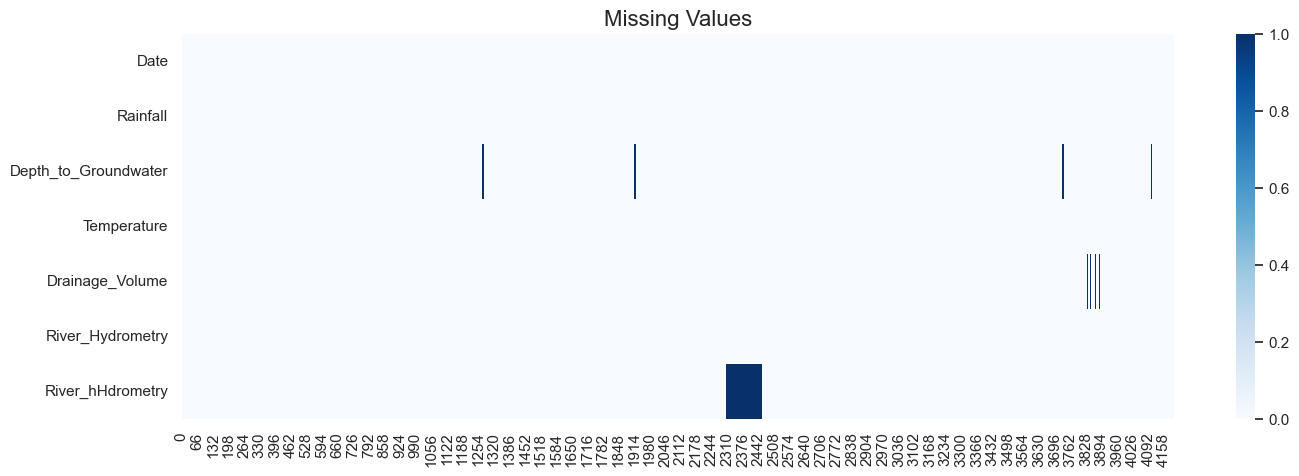

In [107]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

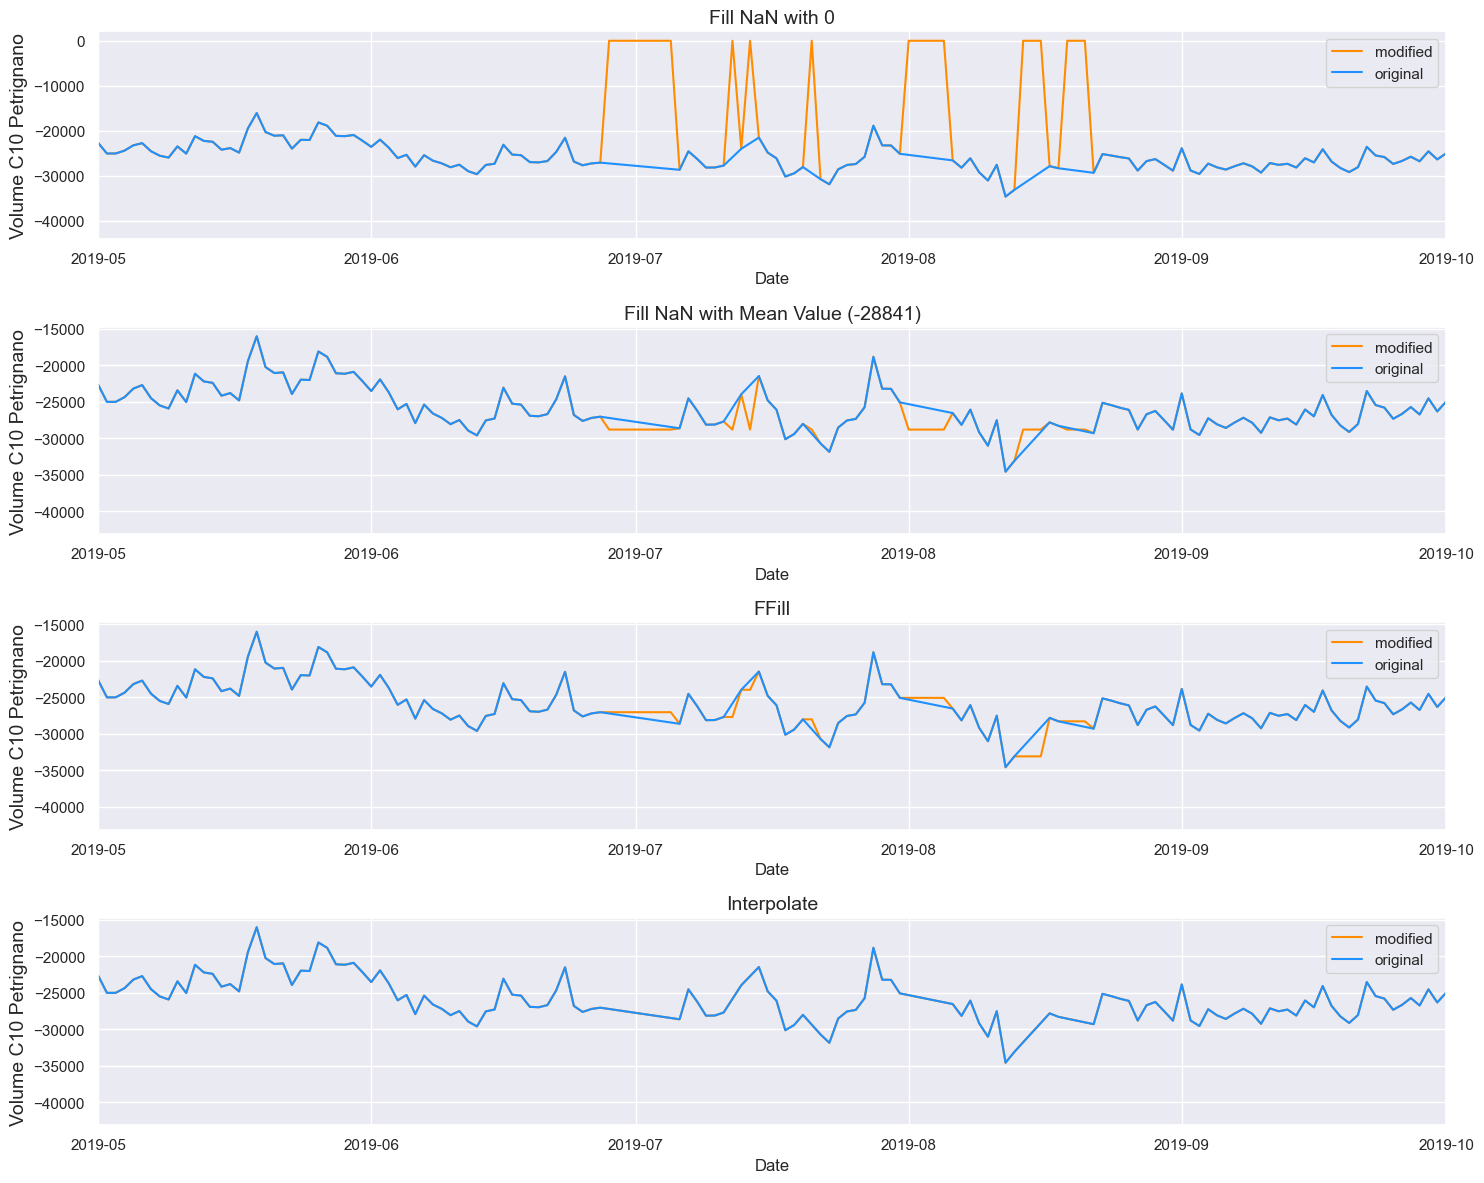

In [108]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['Drainage_Volume'].mean()
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

Filling NaNs with the interpolated values is the best option in this small example, but it requires knowledge of the neighboring value.

In [109]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

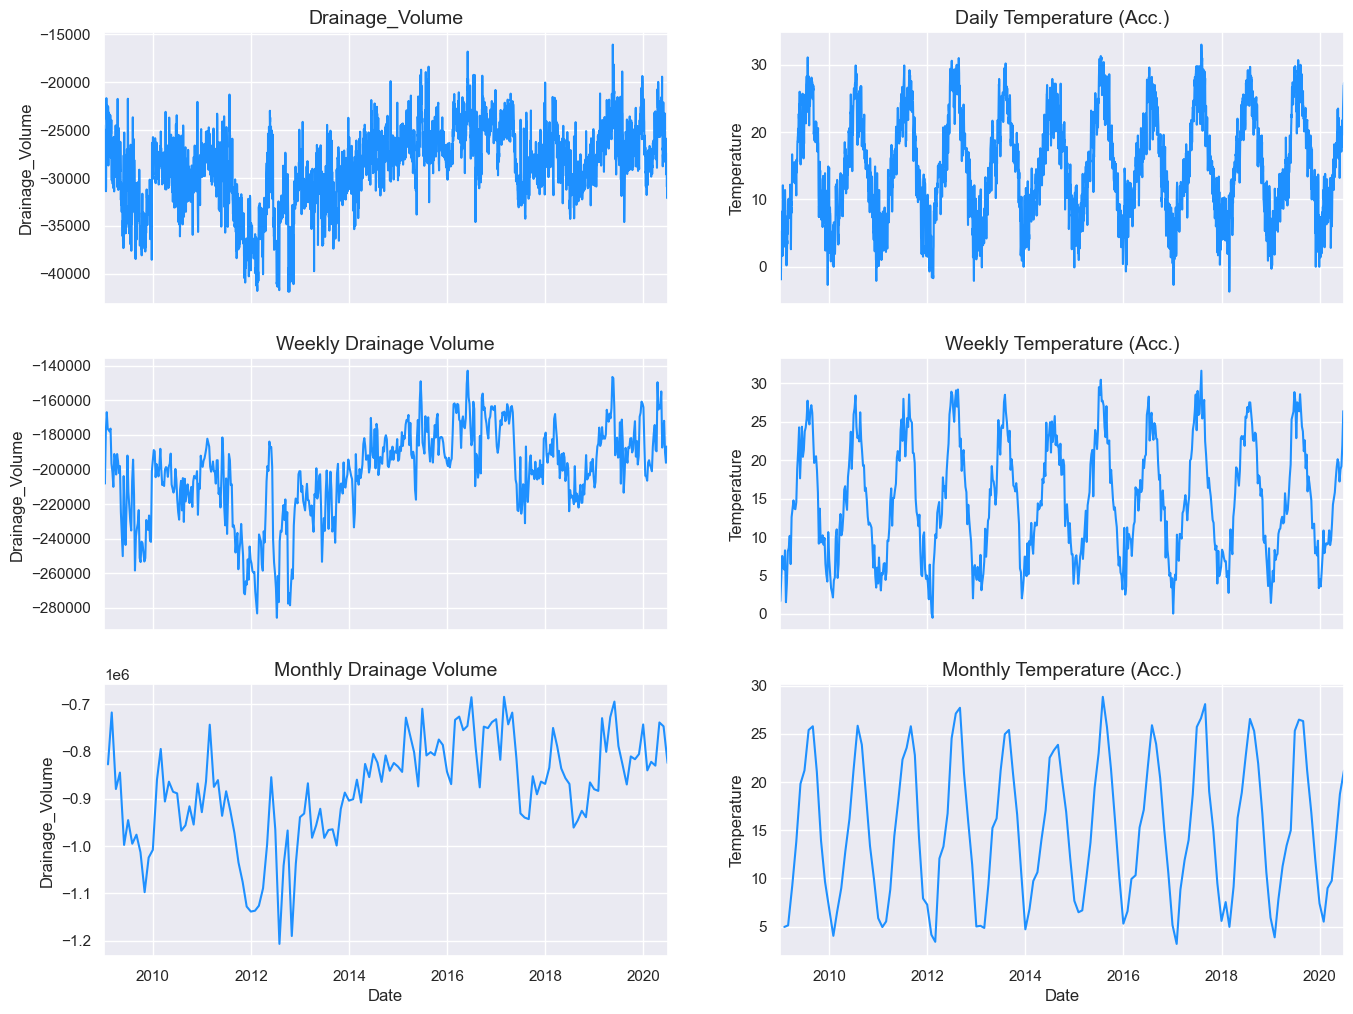

In [113]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

# Daily Drainage Volume
sns.lineplot(x='Date', y='Drainage_Volume', data=df, color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage_Volume', fontsize=14)

# Weekly Drainage Volume
resampled_df = df[['Date', 'Drainage_Volume']].resample('7D', on='Date').sum().reset_index(drop=False)
sns.lineplot(x='Date', y='Drainage_Volume', data=resampled_df, color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

# Monthly Drainage Volume
resampled_df = df[['Date', 'Drainage_Volume']].resample('M', on='Date').sum().reset_index(drop=False)
sns.lineplot(x='Date', y='Drainage_Volume', data=resampled_df, color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

# Set x-axis limits
for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Daily Temperature
sns.lineplot(x='Date', y='Temperature', data=df, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

# Weekly Temperature
resampled_df = df[['Date', 'Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x='Date', y='Temperature', data=resampled_df, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

# Monthly Temperature
resampled_df = df[['Date', 'Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(x='Date', y='Temperature', data=resampled_df, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

# Set x-axis limits
for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

In [116]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['Date',
                 'Depth_to_Groundwater', 
                 'Temperature',
                 'Drainage_Volume', 
                 'River_Hydrometry',
                 'Rainfall'
                ]].resample('7D', on='Date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationarity: 

The check for stationarity can be done via three different approaches:

- Visually: plot time series and check for trends or seasonality.
- Basic statistics: split time series and compare the mean and variance of each partition.
- Statistical test: Augmented Dickey Fuller test.

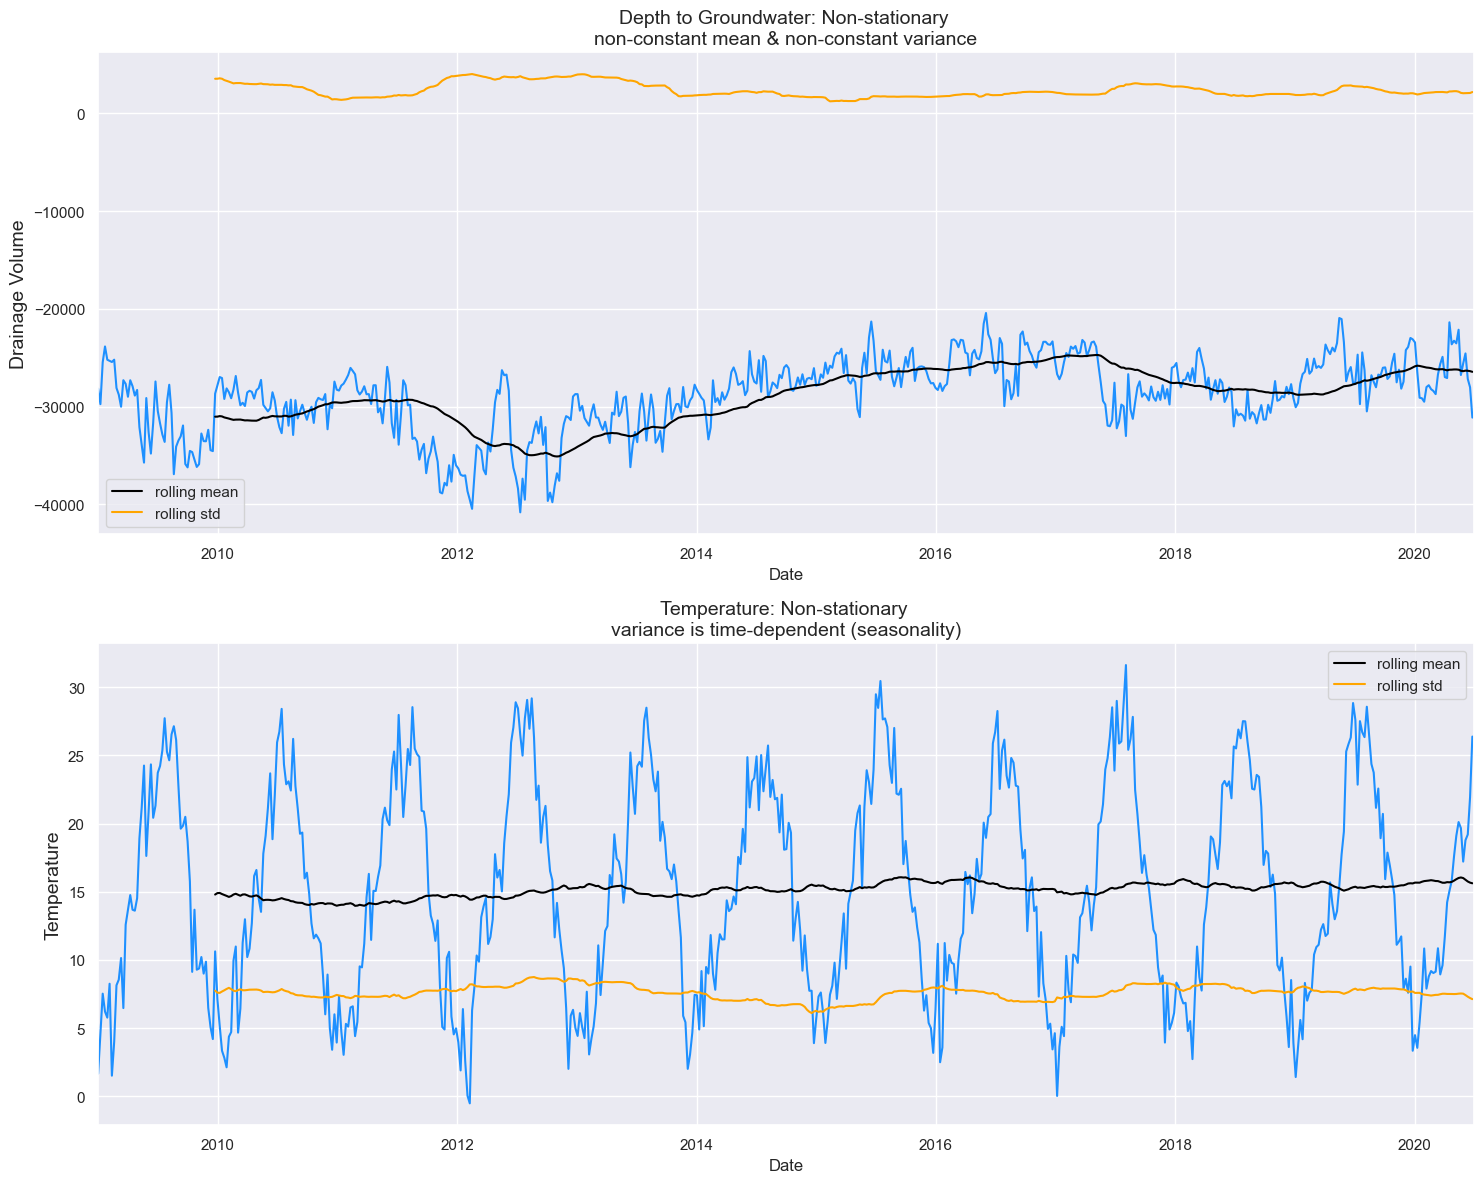

In [117]:
# A year has 52 weeks (52 weeks * 7 days per week) aprox.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['Drainage_Volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Drainage_Volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['Date'], y=df['Temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [122]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 56.0 MB/s eta 0:00:00


In [123]:
from statsmodels.tsa.stattools import adfuller

In [124]:
result = adfuller(df['Depth_to_Groundwater'].values)
result

(-2.8802016493166622,
 0.047699190920208634,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

Now, we are going to check for each variable:

- The p-value is less than 0.05.
- Check the range of the ADF statistic compared with critical_values.

In [ ]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

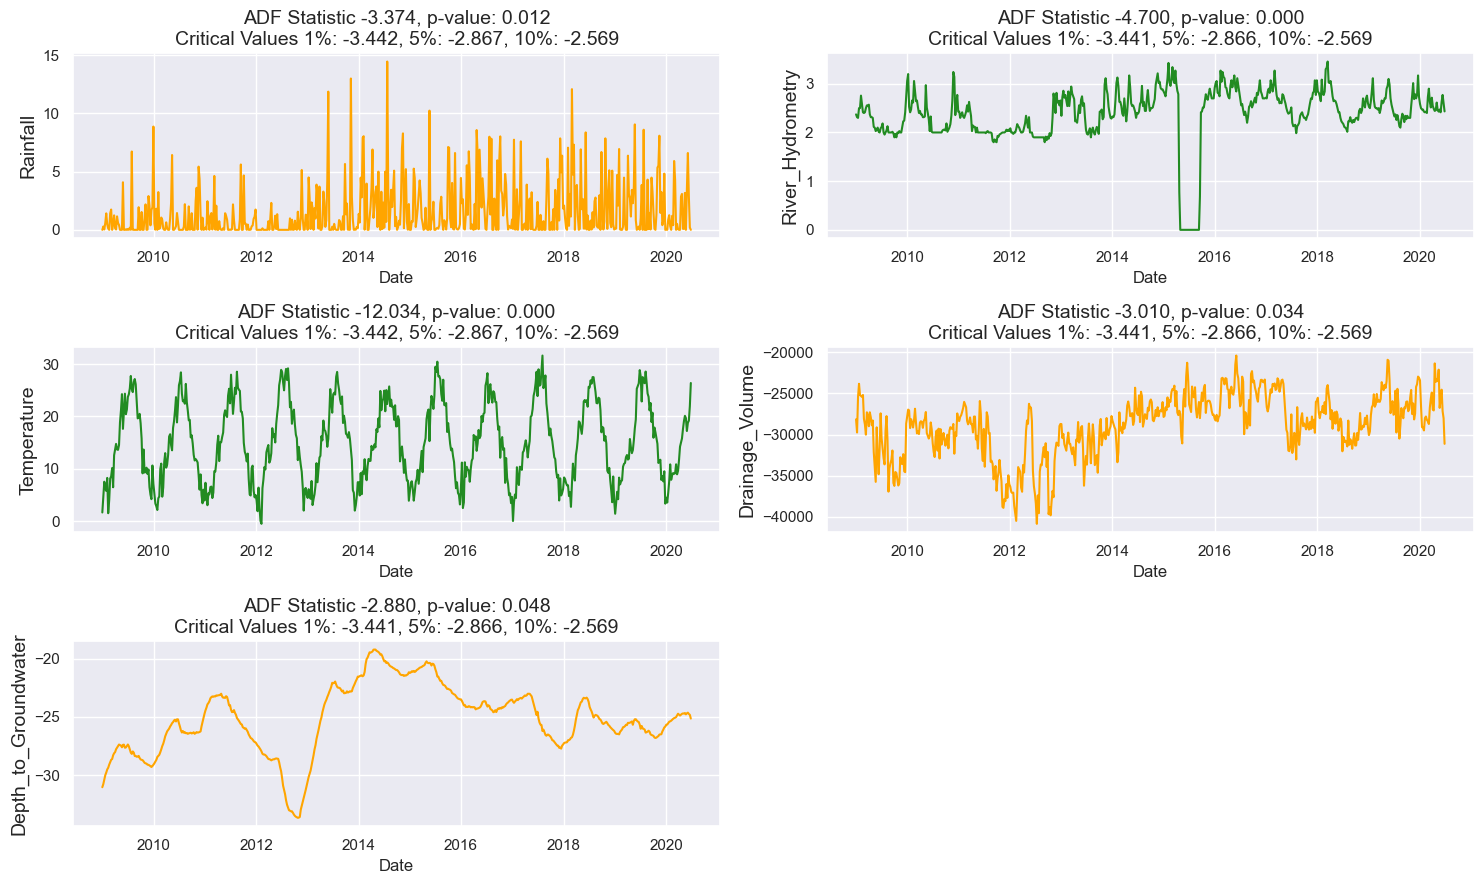

In [125]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['Date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['Rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['Temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['River_Hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['Drainage_Volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['Depth_to_Groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

- Transformation: e.g. log or square root to stabilize non-constant variance

- Differencing: subtracts the current value from the previous

## Transforming:

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

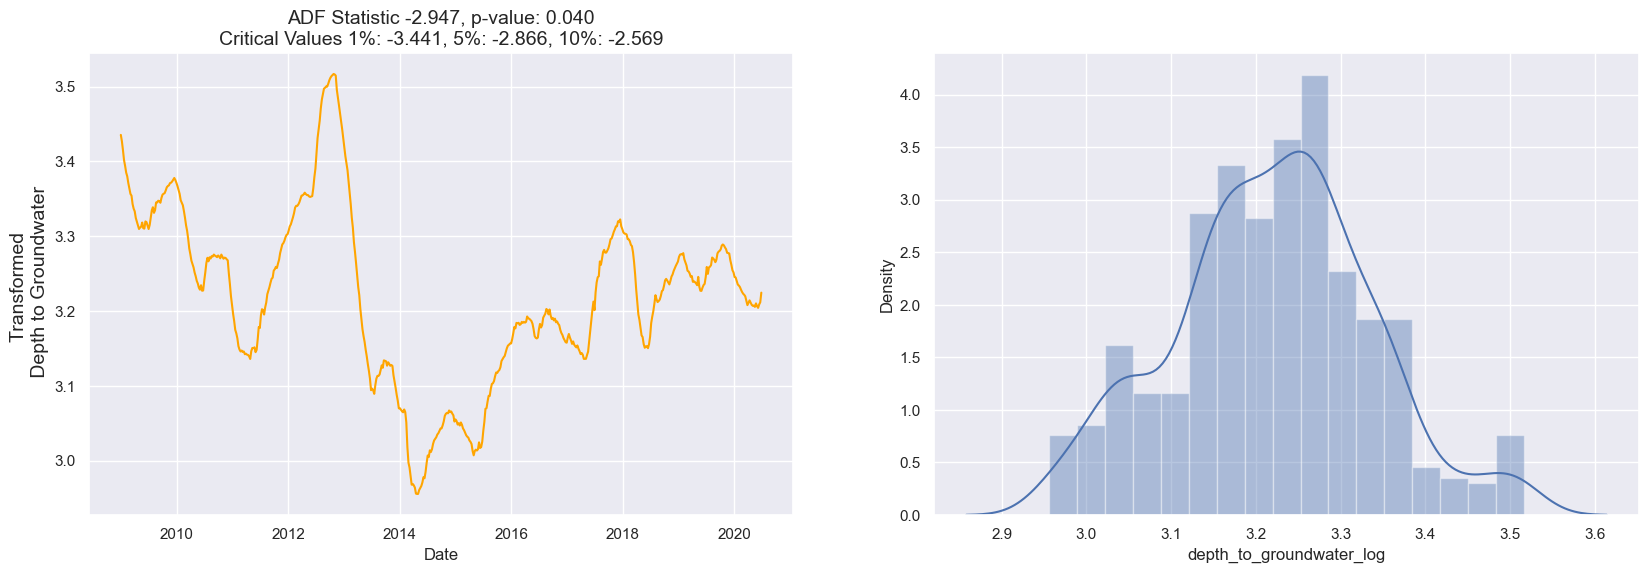

In [126]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['Depth_to_Groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

## Modeling:

In [128]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['Date']
y = df['Depth_to_Groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [129]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Date', 'Depth_to_Groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [130]:
feature_columns = [
    'Rainfall',
    'Temperature',
    'Drainage_Volume',
    'River_Hydrometry',
]
target_column = ['Depth_to_Groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['Date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,Rainfall,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [149]:
from prophet import Prophet

In [150]:
# Train the model
model = Prophet()
model.add_regressor('Rainfall')
model.add_regressor('Temperature')
model.add_regressor('Drainage_Volume')
model.add_regressor('River_Hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.037235583933096


## Conclusions: 

The best results are taken from Univariate LSTM (with rolling window of 1 year) and multi-variate Prophet.
